In [9]:
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
my_layout = widgets.Layout()

In [45]:
def plot_state(t, I, u_t, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, fontsize=20, fontweight='bold', y=.9, color='blue')


    ax[0].plot(t, I, label='Input Current')
    ax[0].set_ylabel('I (nA)')
    ax[0].set_xlabel('Time (ms)')
    ax[0].legend()

    ax[1].plot(t, u_t, label='Membrane Potential')

    ax[1].set_ylabel('u (mV)')
    ax[1].set_xlabel('Time (ms)')
    ax[1].legend()

    plt.show()

<h1 style="background-color:rgb(181 ,50 ,84);color:white;text-align:center">Adaptive exponential Integrate-and-fire model</h1>

A single equation is not sufficient to describe the variety of firing patterns that neurons exhibit in response to a step current. We therefore couple the voltage equation to abstract current variables $w_k$, each described by a linear differential equation. The set of equation- is:
$$\tau_m \frac{d}{dt}u = f(u) - R\sum_kw_k+RI$$
$$\tau_k \frac{d}{dt}w_k = a_k(u-u_{rest})-w_k+b_k\tau_k\sum_f\delta(t-t^f)$$

The adaptive exponential integrate-and-fire model (AdEx) consists of an exponential nonlinearity in the voltage equation coupled to a single adaptation variable $w$:
$$\tau_m \frac{d}{dt}u = -(u-u_{rest}) + \Delta_T\exp\bigg(\frac{u-\vartheta_{rh}}{\Delta_T}\bigg) - Rw+RI$$
$$\tau_w \frac{d}{dt}w = a(u-u_{rest})-w+b\tau_w\sum_f\delta(t-t^f)$$

At each threshold crossing the voltage is reset to $u=u_r$ and the adaptation variable is increased by an amount $b$. The choice of $a$ and $b$ largely determines the firing pattern of the neuron.

### Exponential Integrate-and-fire model

In the exponential integrate-and-fire model the differential equation for the membrane potential is given by: $$\tau \frac{d}{dt}u = -(u-u_{rest})+\Delta_T\exp\bigg(\frac{u-\vartheta_{rh}}{\Delta_T}\bigg) + RI$$

The moment when the membrane potential reaches the numerical threshold $\theta_{reset}$ defines the firing time $t(f)$. After firing, the membrane potential is reset to $u_r$ and integration restarts at time $t(f)+\Delta^{abs}$ where $\Delta^{abs}$ is an absolute refractory time, typically chosen in the range $0<\Delta^{abs}<5ms$. If the numerical threshold is chosen sufficiently high, $\theta_{reset}>>\vartheta_{rh}+\Delta_T$, its exact value does not play any role. The reason is that the upswing of the action potential for $u>>\vartheta_{rh}+\Delta_T$ is so rapid, that it goes to infinity in an incredibly short time. The threshold $\theta_{reset}$ is introduced mainly for numerical convenience. For a formal mathematical analysis of the model, the threshold can be pushed to infinity.

In [36]:
class AdEx():
    def __init__(self, u_rest, tau_m, R, Delta_T, tau_w, a, b, u_r, t_rh):
        self.u_rest = u_rest
        self.tau_m = tau_m
        self.R = R
        self.Delta_T = Delta_T
        self.tau_w = tau_w
        self.a = a
        self.b = b
        self.u_r = u_r
        self.t_rh = t_rh

    def u_dot(self, u, w, i):
        return (-(u - self.u_rest) + self.Delta_T*np.exp((u - self.t_rh)/self.Delta_T) - self.R*w + self.R*i) / self.tau_m

    def w_dot(self, u, w):
        return (self.a*(u - self.u_rest) - w) / self.tau_w

    def simulate(self, t_range, dt, I):
        u_t = np.zeros_like(t_range)
        w_t = np.zeros_like(t_range)

        u_t[0] = self.u_rest
        w_t[0] = 0

        rec_spikes = []
        fired = False

        for i in range(len(t_range) - 1):
            if u_t[i] >= 10:
                u_t[i] = self.u_r
                rec_spikes.append(t_range[i])
                fired = True
            
            u_t[i+1] = u_t[i] + dt*self.u_dot(u_t[i], w_t[i], I[i])
            w_t[i+1] = w_t[i] + dt*self.w_dot(u_t[i], w_t[i]) + self.b*fired
            fired = False

        return u_t, rec_spikes

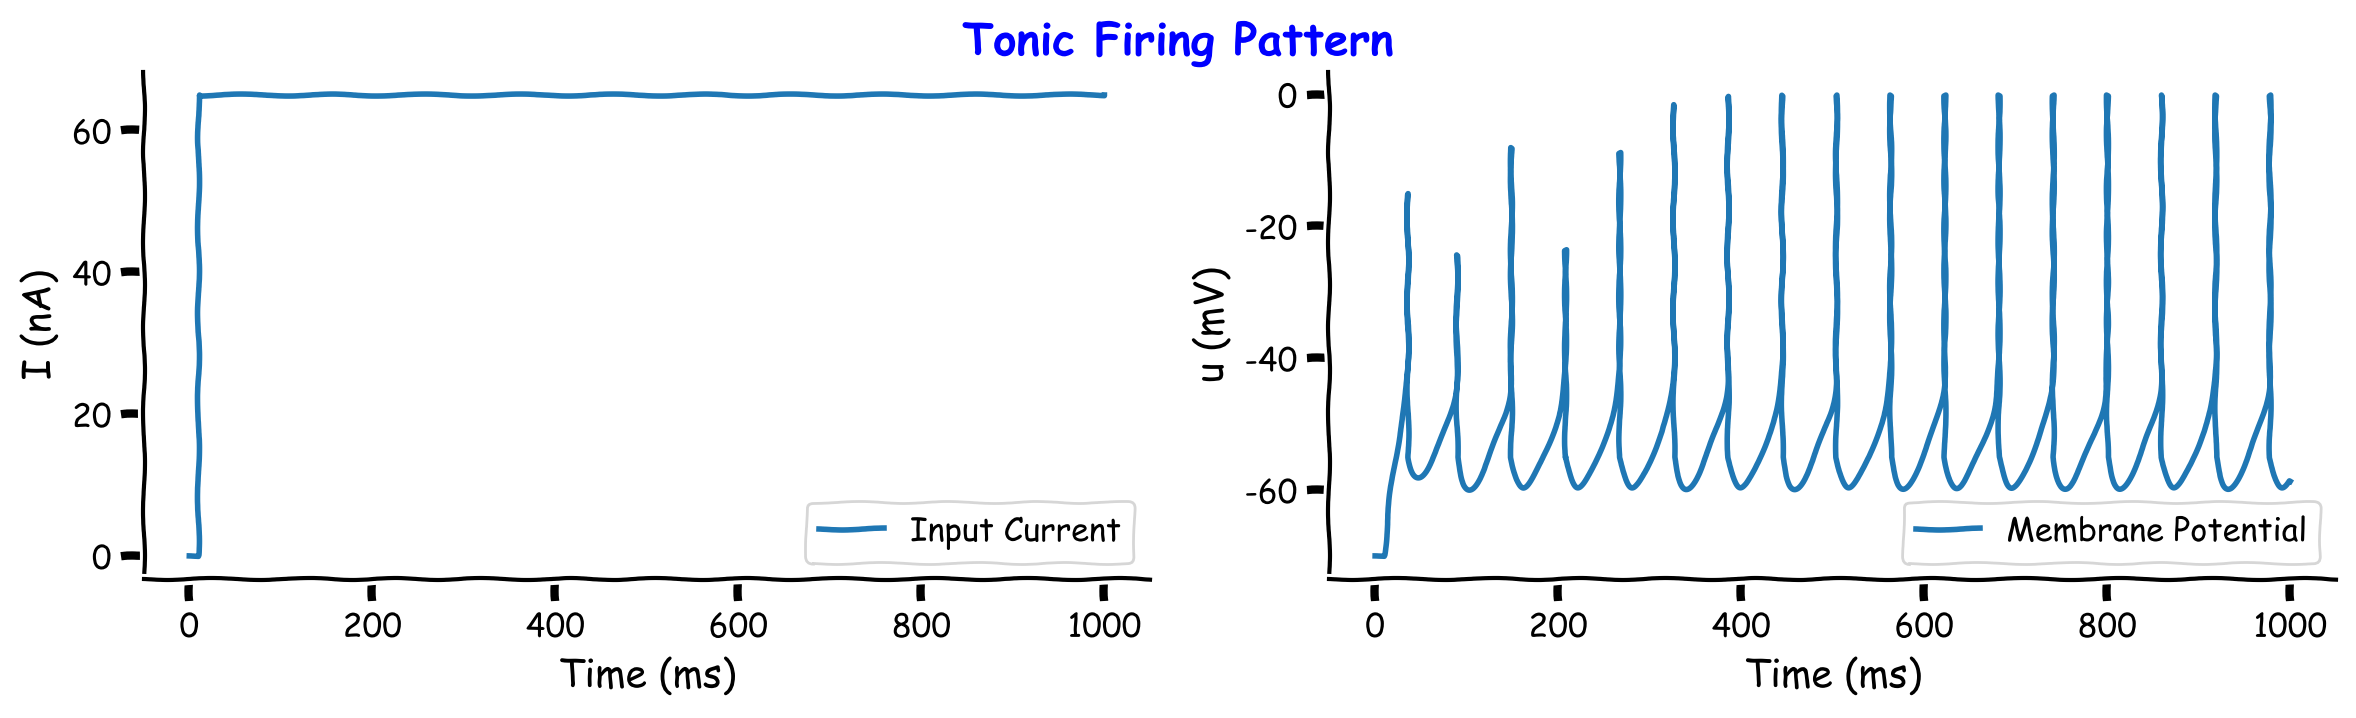

In [43]:
### Tonic firing pattern

# Parameters
u_rest = -70        # resting potential (mV)
tau_m = 20          # membrane time constant (ms)
R = 0.5             # membrane resistance (kΩ)
Delta_T = 2         # spike sharpness (mV)
tau_w = 30          # adaptation time constant (ms)
a = 0               # subthreshold adaptation (nS)
b = 60              # spike-triggered adaptation (pA)
u_r = -55           # reset potential (mV)
t_rh = -50          # threshold potential (mV)
I_amp = 65          # input current amplitude (pA)

# Time range
dt = 0.01
t = np.arange(0, 1000, dt)

# Model
neuron = AdEx(u_rest, tau_m, R, Delta_T, tau_w, a, b, u_r, t_rh)

# Input current
I = np.zeros_like(t)
I[int(10/dt):] = I_amp

# Simulation
u_t, rec_spikes = neuron.simulate(t, dt, I)

# Plot
with plt.xkcd():
    plot_state(t, I, u_t, 'Tonic Firing Pattern')

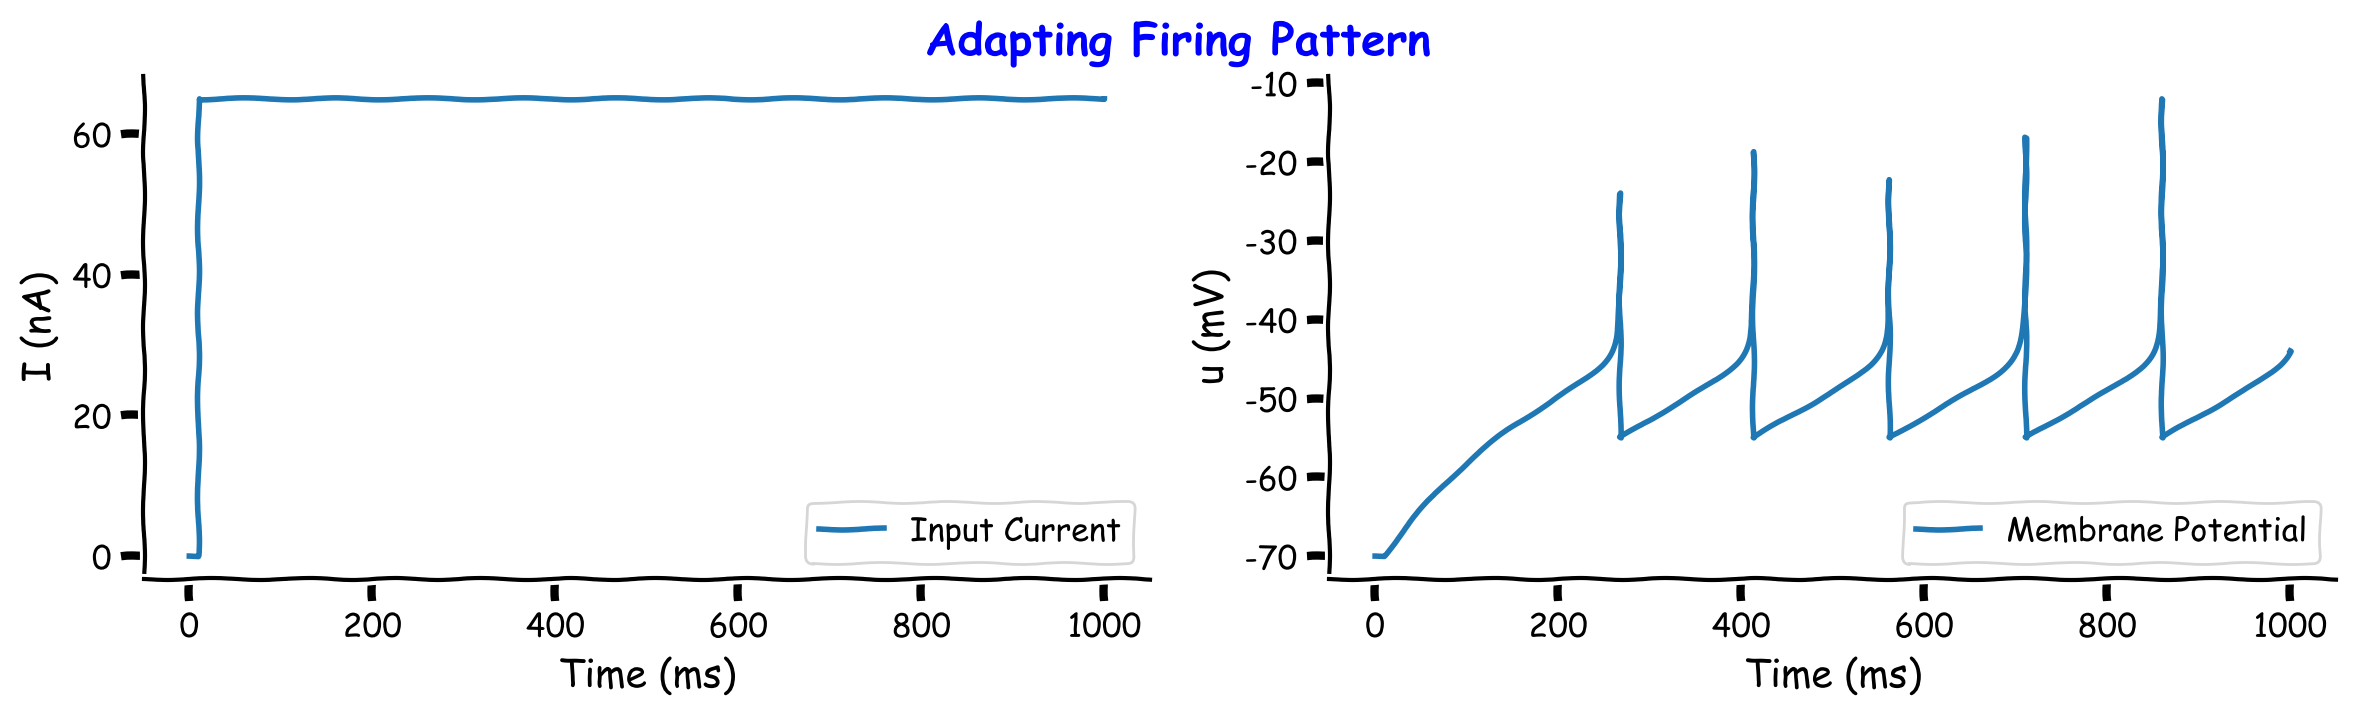

In [42]:
### Adapting firing pattern

# Parameters
u_rest = -70        # resting potential (mV)
tau_m = 200         # membrane time constant (ms)
R = 0.5             # membrane resistance (kΩ)
Delta_T = 2         # spike sharpness (mV)
tau_w = 100         # adaptation time constant (ms)
a = 0               # subthreshold adaptation (nS)
b = 5               # spike-triggered adaptation (pA)
u_r = -55           # reset potential (mV)
t_rh = -50          # threshold potential (mV)
I_amp = 65          # input current amplitude (pA)

# Time range
dt = 0.01
t = np.arange(0, 1000, dt)

# Model
neuron = AdEx(u_rest, tau_m, R, Delta_T, tau_w, a, b, u_r, t_rh)

# Input current
I = np.zeros_like(t)
I[int(10/dt):] = I_amp

# Simulation
u_t, rec_spikes = neuron.simulate(t, dt, I)

# Plot
with plt.xkcd():
    plot_state(t, I, u_t, 'Adapting Firing Pattern')

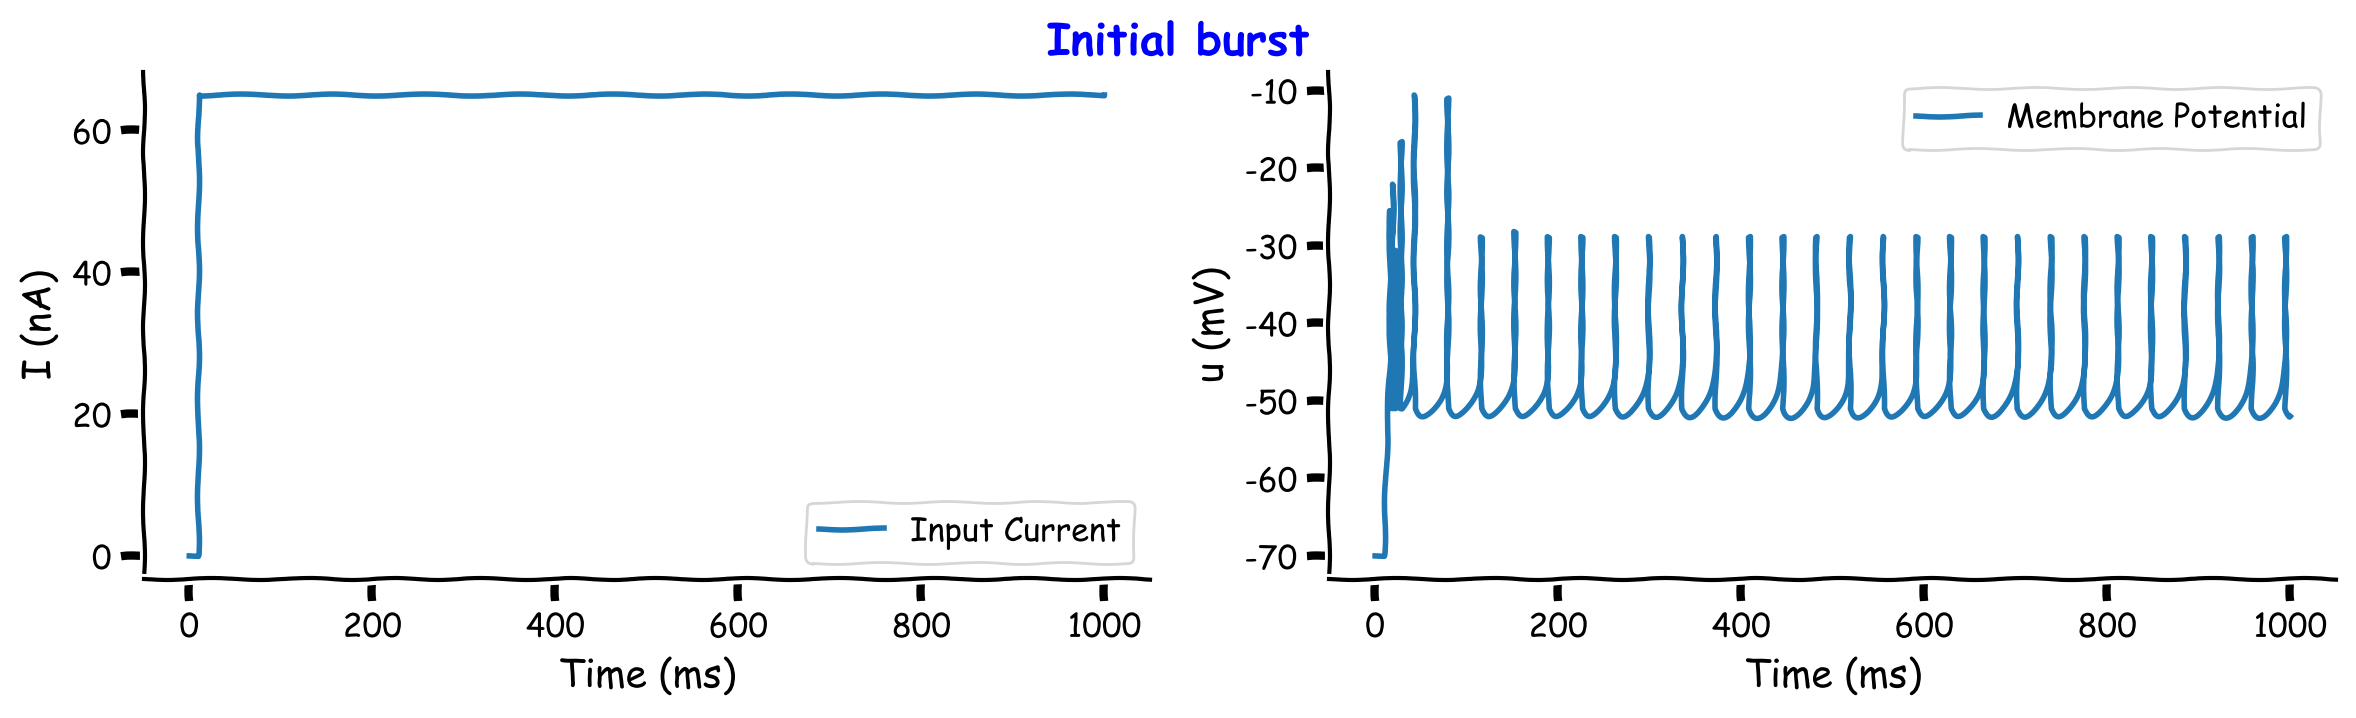

In [44]:
### Initial burst firing pattern

# Parameters
u_rest = -70        # resting potential (mV)
tau_m = 5           # membrane time constant (ms)
R = 0.5             # membrane resistance (kΩ)
Delta_T = 2         # spike sharpness (mV)
tau_w = 100         # adaptation time constant (ms)
a = 0.5             # subthreshold adaptation (nS)
b = 7.              # spike-triggered adaptation (pA)
u_r = -51           # reset potential (mV)
t_rh = -50          # threshold potential (mV)
I_amp = 65          # input current amplitude (pA)

# Time range
dt = 0.01
t = np.arange(0, 1000, dt)

# Model
neuron = AdEx(u_rest, tau_m, R, Delta_T, tau_w, a, b, u_r, t_rh)

# Input current
I = np.zeros_like(t)
I[int(10/dt):] = I_amp

# Simulation
u_t, rec_spikes = neuron.simulate(t, dt, I)

# Plot
with plt.xkcd():
    plot_state(t, I, u_t, 'Initial burst')

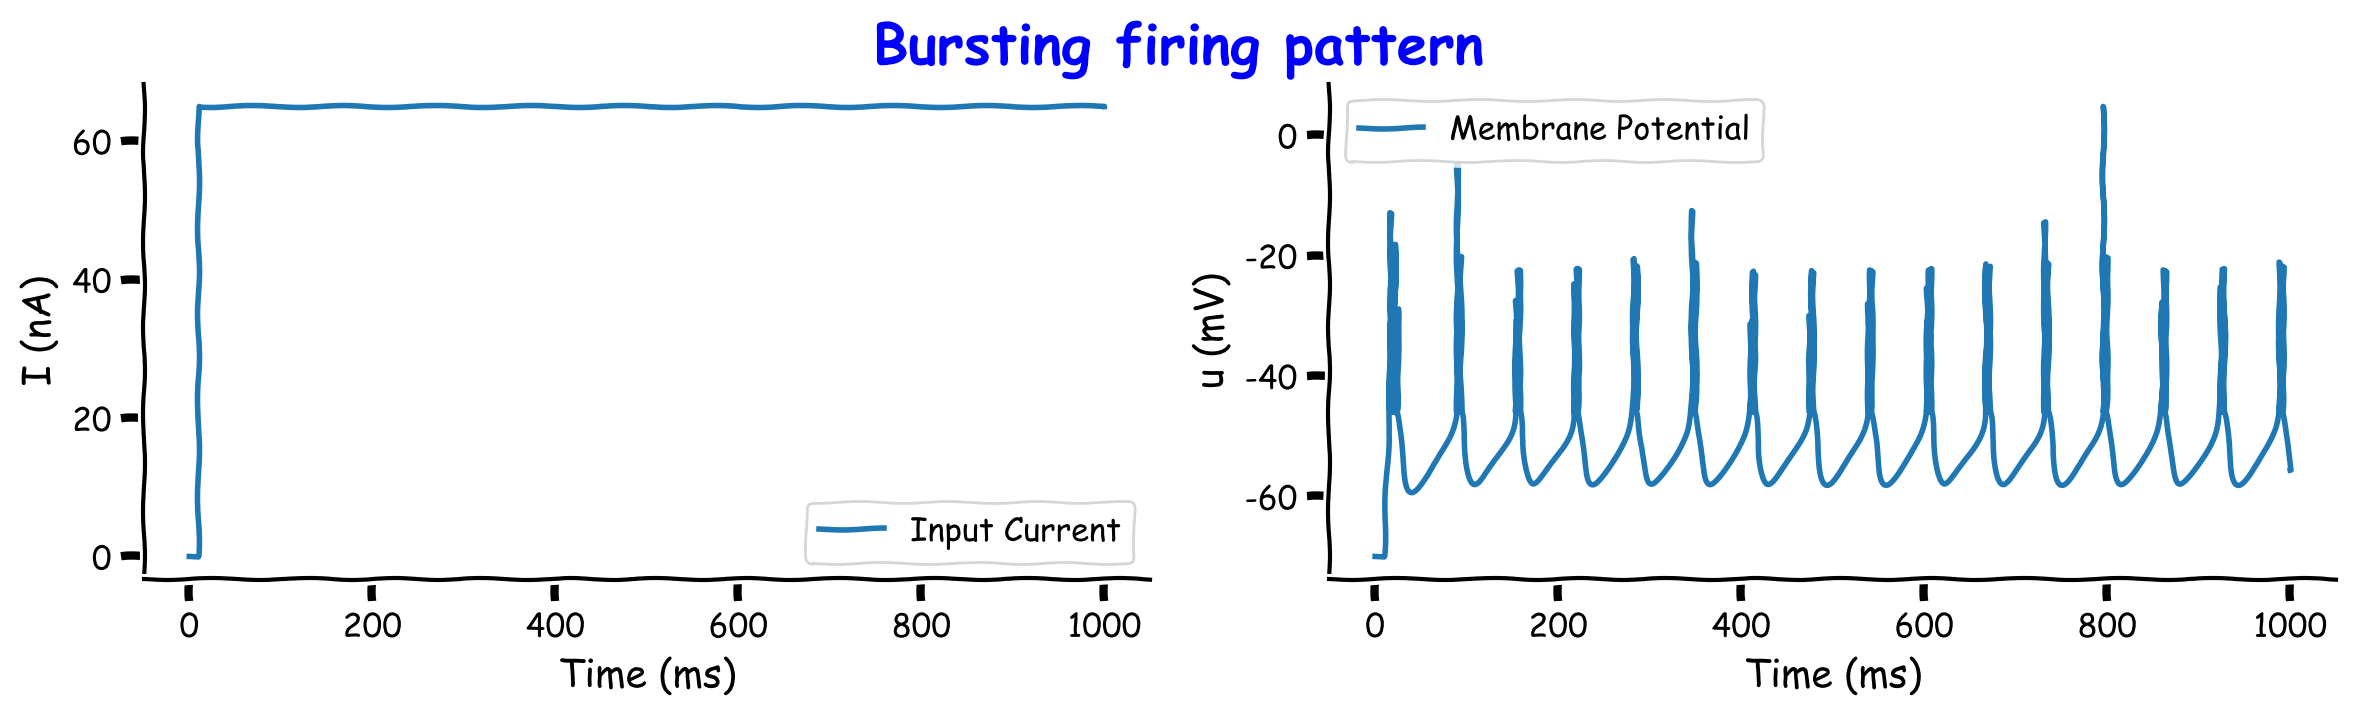

In [48]:
### Bursting firing pattern

# Parameters
u_rest = -70        # resting potential (mV)
tau_m = 5           # membrane time constant (ms)
R = 0.5             # membrane resistance (kΩ)
Delta_T = 2         # spike sharpness (mV)
tau_w = 100         # adaptation time constant (ms)
a = -0.5            # subthreshold adaptation (nS)
b = 7.              # spike-triggered adaptation (pA)
u_r = -46           # reset potential (mV)
t_rh = -50          # threshold potential (mV)
I_amp = 65          # input current amplitude (pA)

# Time range
dt = 0.01
t = np.arange(0, 1000, dt)

# Model
neuron = AdEx(u_rest, tau_m, R, Delta_T, tau_w, a, b, u_r, t_rh)

# Input current
I = np.zeros_like(t)
I[int(10/dt):] = I_amp

# Simulation
u_t, rec_spikes = neuron.simulate(t, dt, I)

# Plot
with plt.xkcd():
    plot_state(t, I, u_t, 'Bursting firing pattern')

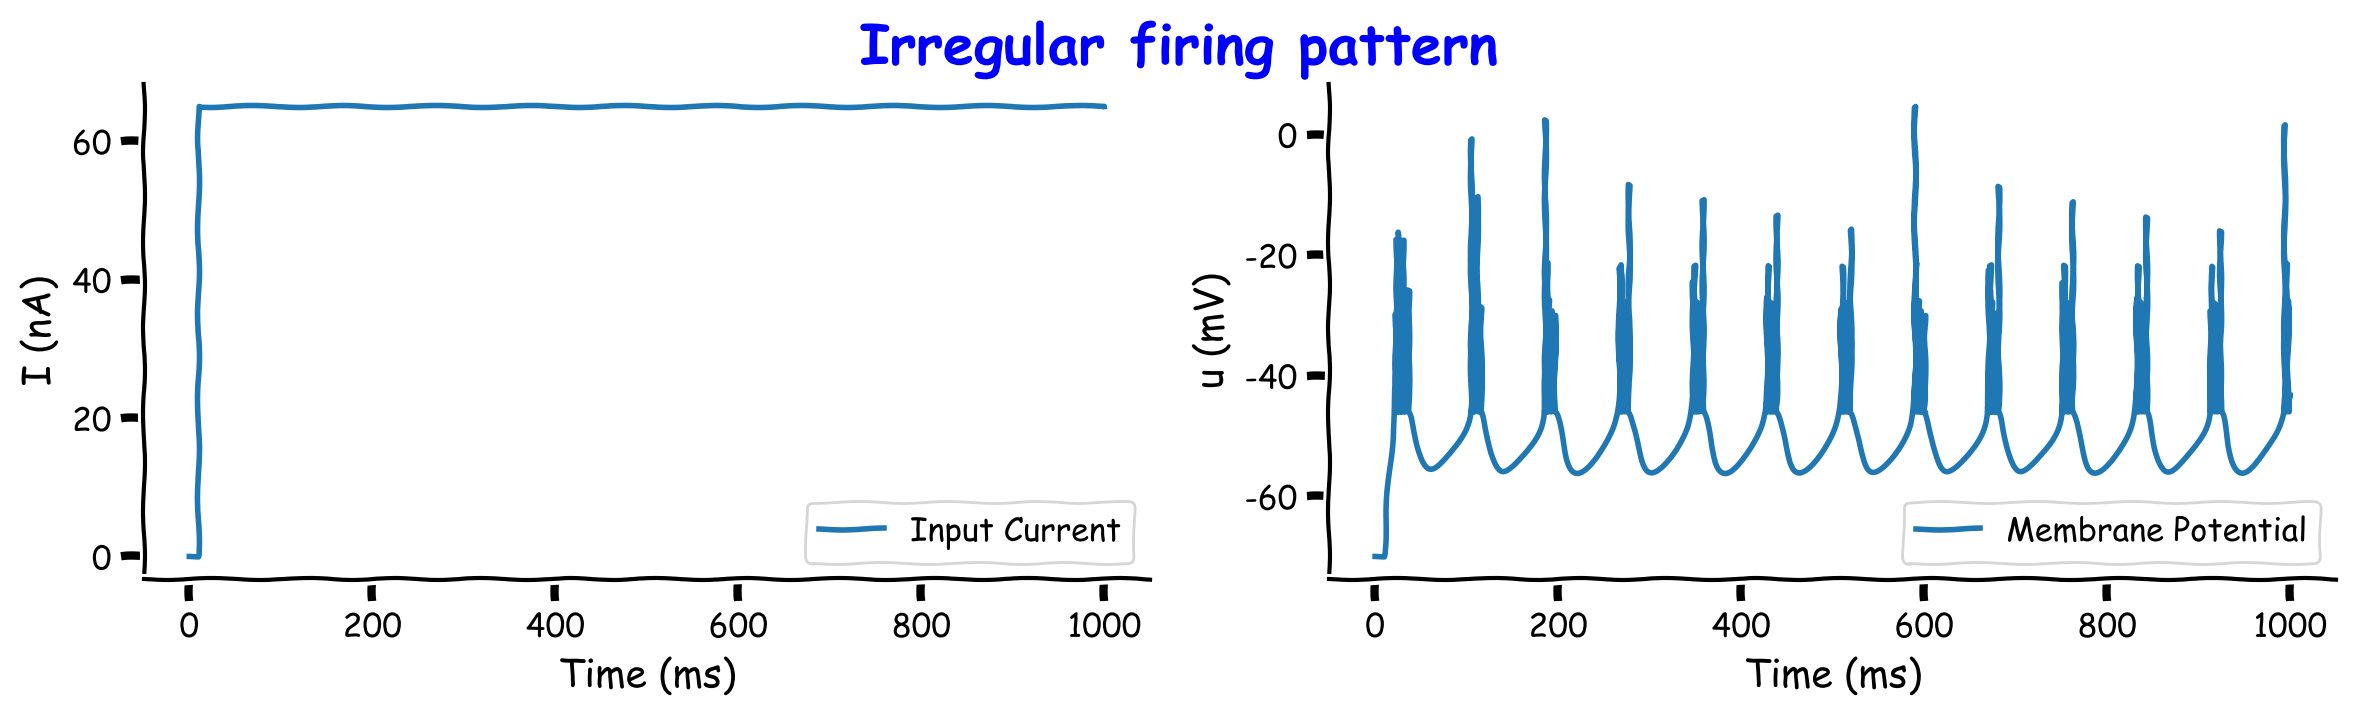

In [49]:
### Irregular firing pattern

# Parameters
u_rest = -70        # resting potential (mV)
tau_m = 9.9         # membrane time constant (ms)
R = 0.5             # membrane resistance (kΩ)
Delta_T = 2         # spike sharpness (mV)
tau_w = 100         # adaptation time constant (ms)
a = -0.5            # subthreshold adaptation (nS)
b = 7.              # spike-triggered adaptation (pA)
u_r = -46           # reset potential (mV)
t_rh = -50          # threshold potential (mV)
I_amp = 65          # input current amplitude (pA)

# Time range
dt = 0.01
t = np.arange(0, 1000, dt)

# Model
neuron = AdEx(u_rest, tau_m, R, Delta_T, tau_w, a, b, u_r, t_rh)

# Input current
I = np.zeros_like(t)
I[int(10/dt):] = I_amp

# Simulation
u_t, rec_spikes = neuron.simulate(t, dt, I)

# Plot
with plt.xkcd():
    plot_state(t, I, u_t, 'Irregular firing pattern')

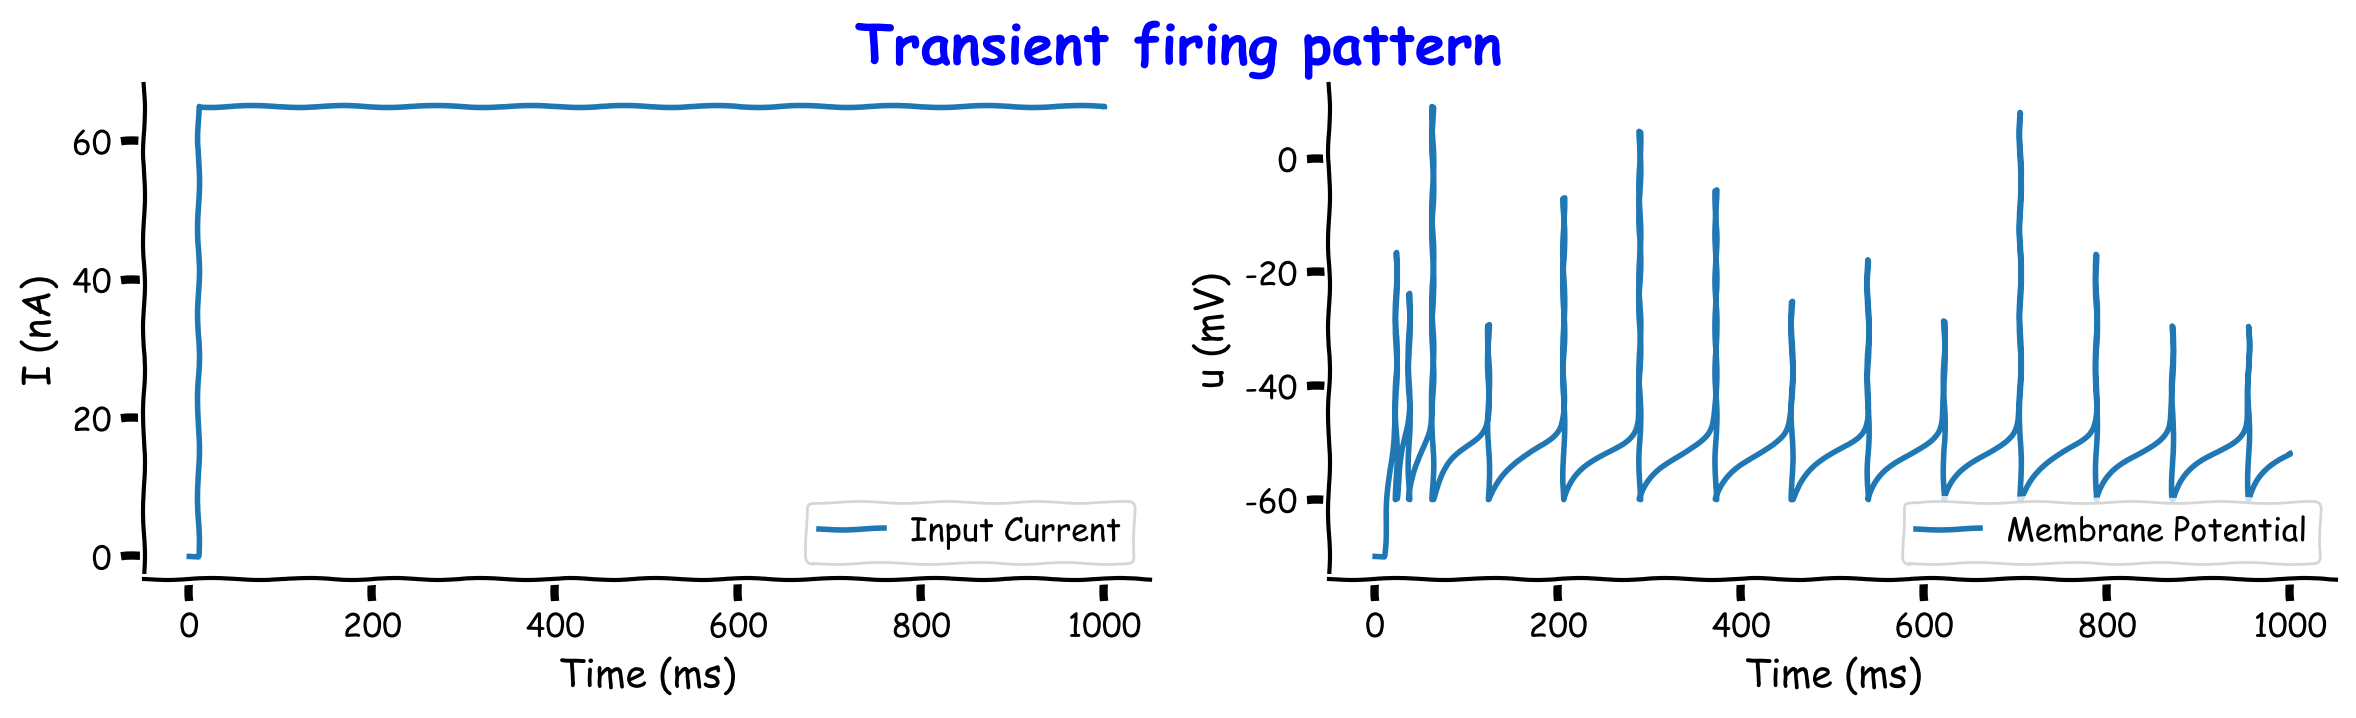

In [52]:
### Transient firing pattern

# Parameters
u_rest = -70        # resting potential (mV)
tau_m = 10          # membrane time constant (ms)
R = 0.5             # membrane resistance (kΩ)
Delta_T = 2         # spike sharpness (mV)
tau_w = 100         # adaptation time constant (ms)
a = 1               # subthreshold adaptation (nS)
b = 10              # spike-triggered adaptation (pA)
u_r = -60           # reset potential (mV)
t_rh = -50          # threshold potential (mV)
I_amp = 65          # input current amplitude (pA)

# Time range
dt = 0.01
t = np.arange(0, 1000, dt)

# Model
neuron = AdEx(u_rest, tau_m, R, Delta_T, tau_w, a, b, u_r, t_rh)

# Input current
I = np.zeros_like(t)
I[int(10/dt):] = I_amp

# Simulation
u_t, rec_spikes = neuron.simulate(t, dt, I)

# Plot
with plt.xkcd():
    plot_state(t, I, u_t, 'Transient firing pattern')

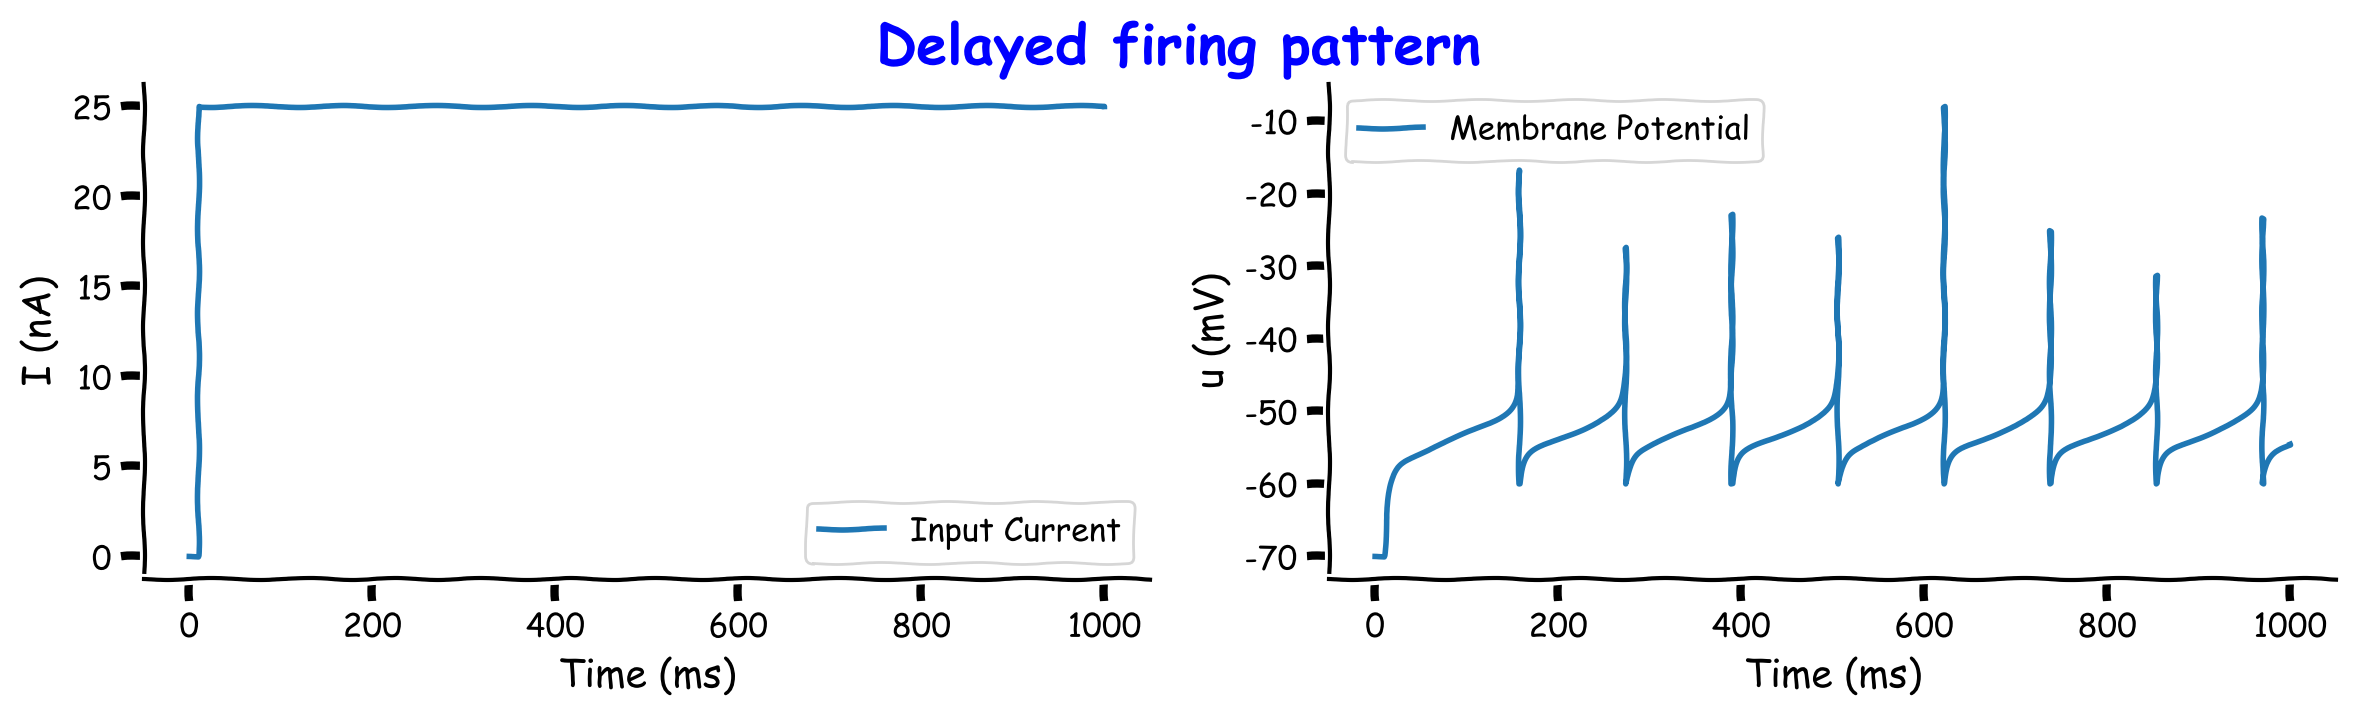

In [53]:
### Delayed firing pattern

# Parameters
u_rest = -70        # resting potential (mV)
tau_m = 5           # membrane time constant (ms)
R = 0.5             # membrane resistance (kΩ)
Delta_T = 2         # spike sharpness (mV)
tau_w = 100         # adaptation time constant (ms)
a = -1              # subthreshold adaptation (nS)
b = 10              # spike-triggered adaptation (pA)
u_r = -60           # reset potential (mV)
t_rh = -50          # threshold potential (mV)
I_amp = 25          # input current amplitude (pA)

# Time range
dt = 0.01
t = np.arange(0, 1000, dt)

# Model
neuron = AdEx(u_rest, tau_m, R, Delta_T, tau_w, a, b, u_r, t_rh)

# Input current
I = np.zeros_like(t)
I[int(10/dt):] = I_amp

# Simulation
u_t, rec_spikes = neuron.simulate(t, dt, I)

# Plot
with plt.xkcd():
    plot_state(t, I, u_t, 'Delayed firing pattern')